In [2]:
import pandas as pd
from itertools import combinations
from scipy.sparse import dok_matrix

# File path
file_path = "../../data/wiki-RfA.txt"

# Read and parse the file
data = []
with open(file_path, "r", encoding="utf-8") as file:
    current_session = None
    for line in file:
        if line.startswith("SRC:"):
            src = line.split("SRC:")[1].strip()
        elif line.startswith("TGT:"):
            tgt = line.split("TGT:")[1].strip()
            # Check if it's a new session (new TGT indicates a new voting session)
            if tgt != current_session:
                current_session = tgt
                session_id = len(data)  # Increment session ID
                data.append({"Session": session_id, "TGT": tgt, "SRCs": []})
        elif line.startswith("VOT:"):
            vot = int(line.split("VOT:")[1].strip())
        elif line.startswith("RES:"):
            res = int(line.split("RES:")[1].strip())
        elif line.startswith("YEA:"):
            yea = int(line.split("YEA:")[1].strip())
        elif line.startswith("DAT:"):
            dat = line.split("DAT:")[1].strip()
        elif line.startswith("TXT:"):
            # Add the SRC to the current session's SRC list
            if data and "SRCs" in data[-1]:
                data[-1]["SRCs"].append(src)

# Create a flat DataFrame
records = []
for session in data:
    for src in session["SRCs"]:
        records.append({"Session": session["Session"], "TGT": session["TGT"], "SRC": src})

df = pd.DataFrame(records)

# Group SRC values by session
grouped = df.groupby("Session")["SRC"].apply(list)

# Create a list of all unique SRCs and a mapping to indices
users = sorted(df["SRC"].unique())
user_to_idx = {user: idx for idx, user in enumerate(users)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

# Initialize a sparse matrix
n_users = len(users)
co_occurrence = dok_matrix((n_users, n_users), dtype=int)

# Populate the co-occurrence matrix
for user_list in grouped:
    for user1, user2 in combinations(user_list, 2):
        idx1, idx2 = user_to_idx[user1], user_to_idx[user2]
        co_occurrence[idx1, idx2] += 1
        co_occurrence[idx2, idx1] += 1

# Convert the sparse matrix to a DataFrame for display
co_occurrence_df = pd.DataFrame.sparse.from_spmatrix(
    co_occurrence, index=users, columns=users
)

# Display the sparse co-occurrence matrix
print("Sparse Co-occurrence Matrix:")
print(co_occurrence_df)

# Optionally save to a CSV
# co_occurrence_df.to_csv("wiki_rfa_co_occurrence.csv")


Sparse Co-occurrence Matrix:
                         !---slappdash---!  %D0%90  'sed  (.Y.)  (:Julien:)  \
                   5020                  0       9     0      0           0   
!---slappdash---!     0                  0       0     0      0           0   
%D0%90                9                  0       0     0      0           0   
'sed                  0                  0       0     0      0           0   
(.Y.)                 0                  0       0     0      0           0   
...                 ...                ...     ...   ...    ...         ...   
とある白い猫                1                  0       0     0      0           0   
シ                     3                  0       0     0      0           0   
石                     0                  0       0     0      0           0   
龗                     1                  0       0     0      0           0   
완젬스                   0                  0       0     0      0           0   

                   (ae

In [13]:
import pandas as pd

# Assuming `co_occurrence_df` is the co-occurrence DataFrame from the previous step

# Calculate Weighted Participation (sum of co-occurrence values)
weighted_participation = co_occurrence_df.sum(axis=1)

# Combine results into a DataFrame for ranking
power_voters = pd.DataFrame({
    "User": co_occurrence_df.index,
    "Weighted Participation": weighted_participation
})

# Load scores.csv
scores = pd.read_csv("../../data/scores.csv")  # Update the path as needed

# Merge the power voters DataFrame with the scores DataFrame
power_voters = power_voters.merge(scores, left_on="User", right_on="username", how="left")

# Remove rows with missing data (users without total_score or Weighted Participation)
power_voters = power_voters.dropna(subset=["Weighted Participation", "total_score"])

# Sort primarily by Weighted Participation and then by Admin Score (total_score)
power_voters = power_voters.sort_values(
    by=["Weighted Participation", "total_score"],
    ascending=[False, False]
)

# Reset index for better readability
power_voters.reset_index(drop=True, inplace=True)

In [14]:
top_n = 10  # Adjust as needed
print(f"Top {top_n} Power Voters:")
for _, row in power_voters.head(top_n).iterrows():
    user = f'"{row["User"]}"'  # Add quotes around the username
    weighted_participation = row["Weighted Participation"]
    total_score = row["total_score"]
    print(f"User: {user}, Weighted Participation: {weighted_participation}, Admin Score: {total_score}")


Top 10 Power Voters:
User: "Siva1979", Weighted Participation: 89307, Admin Score: 827.0
User: "Acalamari", Weighted Participation: 61987, Admin Score: 1300.0
User: "Stifle", Weighted Participation: 57998, Admin Score: 1297.0
User: "Bearian", Weighted Participation: 56537, Admin Score: 1300.0
User: "Xoloz", Weighted Participation: 53741, Admin Score: 865.0
User: "Newyorkbrad", Weighted Participation: 47998, Admin Score: 1017.0
User: "Axl", Weighted Participation: 47218, Admin Score: 837.0
User: "Malinaccier", Weighted Participation: 47010, Admin Score: 1180.0
User: "Merovingian", Weighted Participation: 46465, Admin Score: 933.0
User: "MONGO", Weighted Participation: 43164, Admin Score: 1039.0


In [15]:
# Optionally save the results to a CSV file
power_voters.to_csv("../../data/power_voters_with_scores.csv", index=False)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


Loading and parsing data...
Parsed 198275 votes.
Filtering users with sufficient voting history...
Filtered down to 1021 users.
Analyzing sentiment...
Calculating correlation metrics...
Correlation coefficient: 0.32
Visualizing results...


<Figure size 1200x800 with 0 Axes>

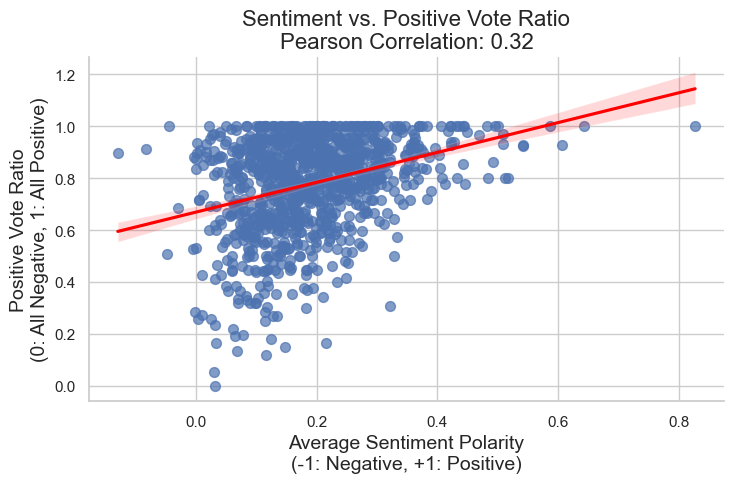

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
import os

# Ensure necessary NLTK data is available
try:
    nltk.download('punkt')
except:
    nltk.download('punkt', download_dir='/custom/path/for/nltk_data')
    nltk.data.path.append('/custom/path/for/nltk_data')

# Step 1: Parse the dataset
def parse_rfa_file(file_path):
    """
    Reads and parses the wiki-RfA.txt file, returning a DataFrame.

    Args:
        file_path (str): Path to the input file.

    Returns:
        pd.DataFrame: Parsed data as a DataFrame.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r', encoding='utf-8') as file:
        raw_data = file.read()

    entries = raw_data.strip().split('\n\n')
    votes = []

    for entry in entries:
        vote = {}
        lines = entry.strip().split('\n')
        for line in lines:
            if ':' not in line:
                continue
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip().strip("'''").strip('"').strip("'")
            vote[key] = value
        votes.append(vote)

    df = pd.DataFrame(votes)

    numeric_fields = ['VOT', 'RES', 'YEA']
    for field in numeric_fields:
        if field in df.columns:
            df[field] = pd.to_numeric(df[field], errors='coerce')

    return df

# Step 2: Filter users with diverse voting history
def filter_users(df, min_years=4):
    """
    Keeps users with votes spanning at least a minimum number of years.

    Args:
        df (pd.DataFrame): Input DataFrame.
        min_years (int): Minimum distinct voting years.

    Returns:
        pd.DataFrame: Filtered data.
    """
    vote_counts = df.groupby('SRC')['YEA'].nunique().reset_index()
    eligible_users = vote_counts[vote_counts['YEA'] >= min_years]['SRC']
    return df[df['SRC'].isin(eligible_users)]

# Step 3: Analyze sentiment of votes
def analyze_sentiment(df):
    """
    Adds a sentiment polarity score for each vote.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with sentiment polarity.
    """
    def compute_polarity(text):
        try:
            return TextBlob(text).sentiment.polarity
        except Exception:
            return 0.0

    df = df.copy()  # Create a copy to avoid chained assignment issues
    df['Polarity'] = df['TXT'].apply(compute_polarity)
    return df


# Step 4: Calculate correlation metrics
def compute_correlation_ratio(df):
    """
    Computes the correlation between sentiment polarity and vote positivity.

    Args:
        df (pd.DataFrame): DataFrame with sentiment data.

    Returns:
        pd.DataFrame: Aggregated data.
        float: Correlation coefficient.
    """
    vote_aggregation = df.groupby('SRC').agg(
        Positive_Votes=('VOT', lambda x: (x > 0).sum()),
        Negative_Votes=('VOT', lambda x: (x < 0).sum())
    ).reset_index()

    vote_aggregation['Positive_Vote_Ratio'] = vote_aggregation.apply(
        lambda row: row['Positive_Votes'] / (row['Positive_Votes'] + row['Negative_Votes'])
        if (row['Positive_Votes'] + row['Negative_Votes']) > 0 else None,
        axis=1
    )

    vote_aggregation.dropna(subset=['Positive_Vote_Ratio'], inplace=True)

    avg_polarity = df.groupby('SRC')['Polarity'].mean().reset_index().rename(columns={'Polarity': 'Average_Polarity'})
    merged_df = pd.merge(vote_aggregation, avg_polarity, on='SRC')

    correlation = merged_df['Average_Polarity'].corr(merged_df['Positive_Vote_Ratio'])
    return merged_df, correlation

# Step 5: Visualize the results
def plot_correlation_ratio(merged_df, correlation):
    """
    Creates a scatterplot with a regression line to visualize correlation.

    Args:
        merged_df (pd.DataFrame): Data with calculated metrics.
        correlation (float): Correlation coefficient.
    """
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")

    sns.lmplot(
        x='Average_Polarity', 
        y='Positive_Vote_Ratio', 
        data=merged_df,
        aspect=1.5, 
        scatter_kws={'s': 50, 'alpha': 0.7}, 
        line_kws={'color': 'red'}
    )

    plt.title(f"Sentiment vs. Positive Vote Ratio\nPearson Correlation: {correlation:.2f}", fontsize=16)
    plt.xlabel("Average Sentiment Polarity\n(-1: Negative, +1: Positive)", fontsize=14)
    plt.ylabel("Positive Vote Ratio\n(0: All Negative, 1: All Positive)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Main workflow
def main():
    file_path = '../../data/wiki-RfA.txt'

    print("Loading and parsing data...")
    df = parse_rfa_file(file_path)
    print(f"Parsed {len(df)} votes.")

    print("Filtering users with sufficient voting history...")
    filtered_df = filter_users(df, min_years=4)
    print(f"Filtered down to {filtered_df['SRC'].nunique()} users.")

    if filtered_df.empty:
        print("No users meet the criteria for analysis.")
        return

    print("Analyzing sentiment...")
    filtered_df = analyze_sentiment(filtered_df)

    print("Calculating correlation metrics...")
    merged_df, correlation = compute_correlation_ratio(filtered_df)
    print(f"Correlation coefficient: {correlation:.2f}")

    print("Visualizing results...")
    plot_correlation_ratio(merged_df, correlation)

if __name__ == "__main__":
    main()
